<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_KalmanFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman filtering/prediction/smoothing

Example 6.5 (Local Level Model) from Shumway and Stoffer "Time Series Analysis and Its Applications", 4th ed

Use their `astsa` package and its `Ksmooth0` function (which does prediction, filtering and smoothing all in one)

In [1]:
install.packages('astsa')
library(astsa)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [46]:
# generate data
set.seed(1)
num <- 50 
w   <- rnorm(num+1,0,1)
v   <- rnorm(num,0,1) 
mu  <- cumsum(w) # state: mu[0], mu[1],..., mu[50] 
y   <- mu[-1]+ v # obs: y[1],..., y[50]

#### Plot the data
Latent variables $\mu_t$ and observations $y_t$

In [ ]:
# start figure 
Time <- 1:num 

options(repr.plot.width = 12, repr.plot.height=6)
plot(Time, mu[-1],type='b')
lines(Time,y,type='b',col='red',lty=2)
legend(30,1, legend=c("X (latent state)", "Y (noisy observation)"),
       col=c(1,2), lty=1:2, cex=1.3)

#### Run the Kalman filter

In [47]:
# filter and smooth and predict (Ksmooth0 does all of them)
ks  <- astsa::Ksmooth0(num, y, A=1, mu0=0, Sigma0=1, Phi=1, cQ=1, cR=1) 

Plot the results. We have:
1. $y$, the observations
2. `ks$xp`, the Kalman predictions
3. `ks$xf`, the Kalman filter
4. `ks$xs`, the Kalman smoother

These are all estimates of the latent variable $\mu$, so let's show the differences between them and $\mu$

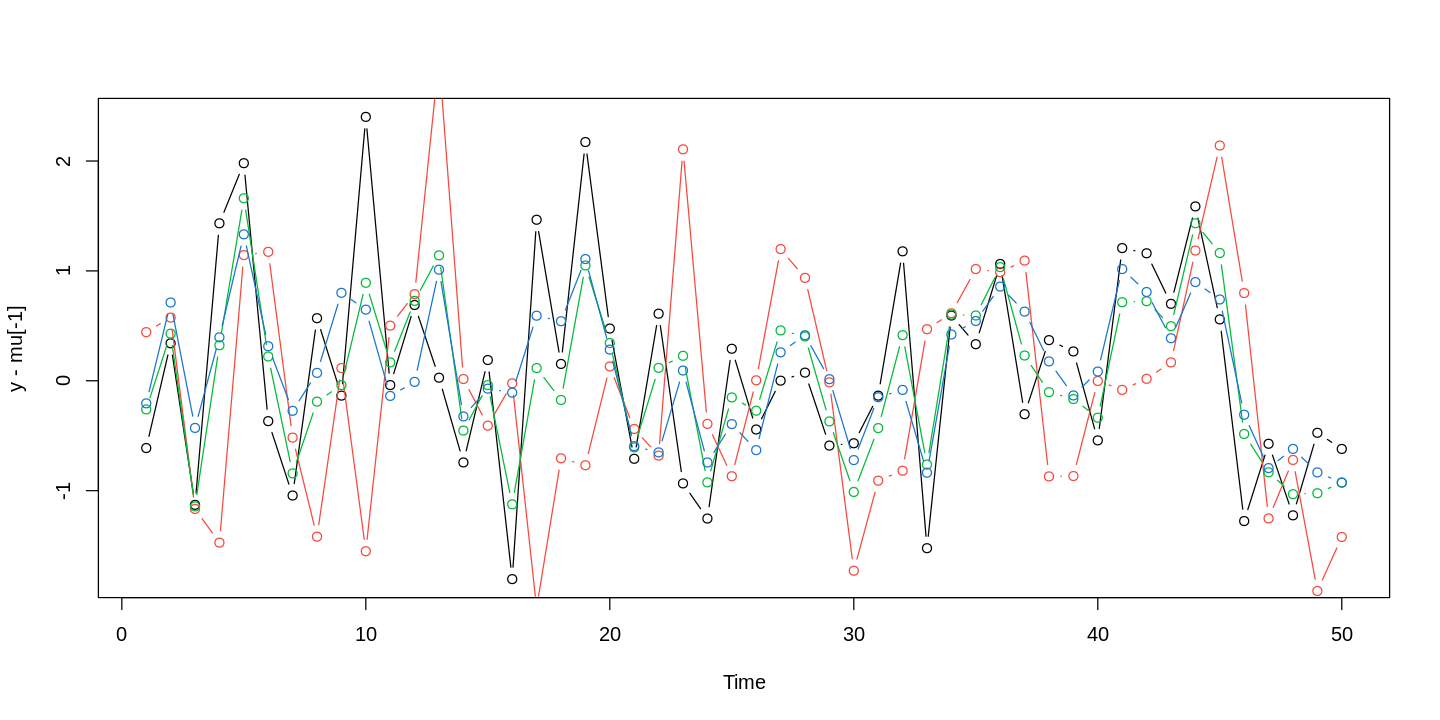

In [23]:
options(repr.plot.width = 12, repr.plot.height=6)
plot( Time, y - mu[-1], type='b' )
lines( Time, ks$xp - mu[-1], type='b', col=2 )
lines( Time, ks$xf - mu[-1], type='b', col=3 )
lines( Time, ks$xs - mu[-1], type='b', col=4 )

That's a little hard to interpret. We can also look at the histograms to see if one method is better than another

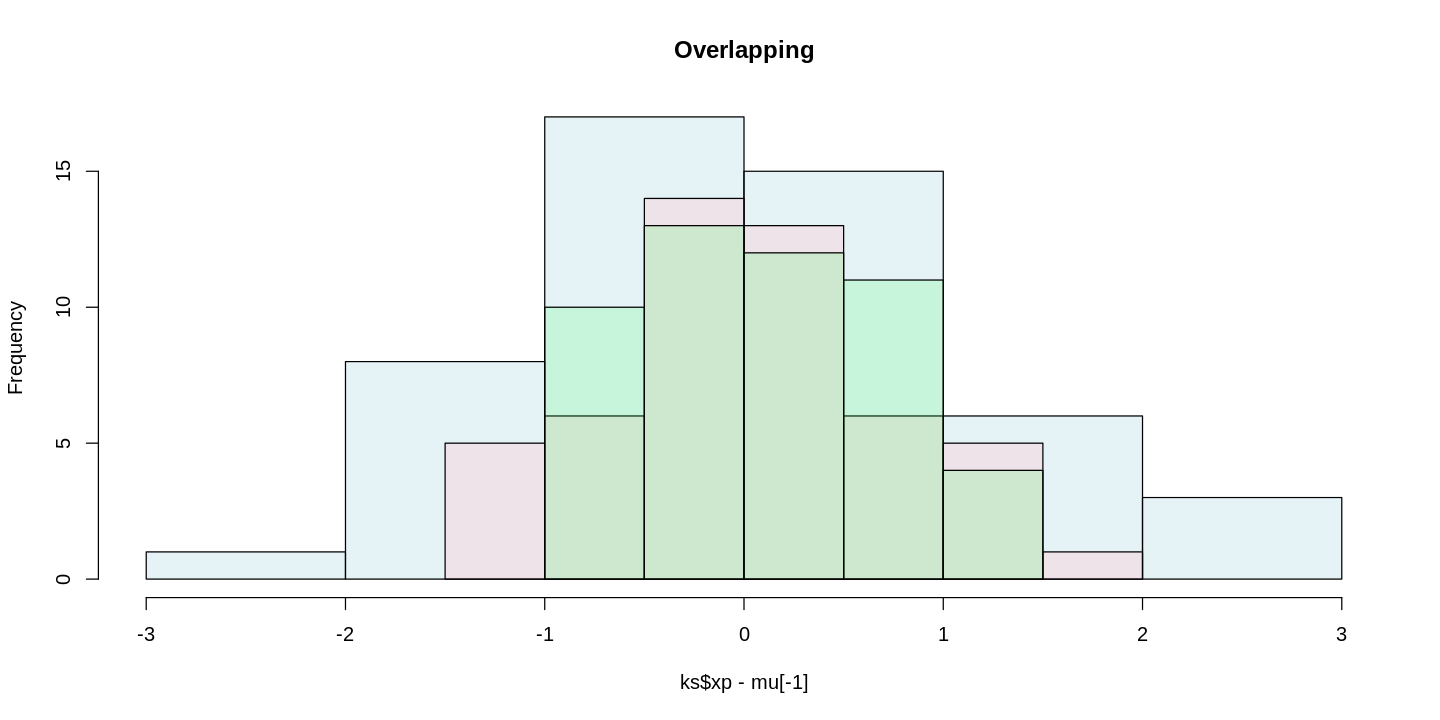

In [41]:
hist.p <- hist( ks$xp - mu[-1], plot=FALSE)
hist.f <- hist( ks$xf - mu[-1], plot=FALSE)
hist.s <- hist( ks$xs - mu[-1], plot=FALSE)

c1 <- rgb(173,216,230, max = 255, alpha = 80, names = "lt.blue")
c2 <- rgb(255,192,203, max = 255, alpha = 80, names = "lt.pink")
c3 <- rgb(80,255,103,  max = 255, alpha = 50, names = "lt.green")

plot(hist.p, col = c1, main='Overlapping')
plot(hist.f, col = c2, add = TRUE)
plot(hist.s, col = c3, add = TRUE)

Even better, let's convert the histogram to an estimate of the PDF of each distribution

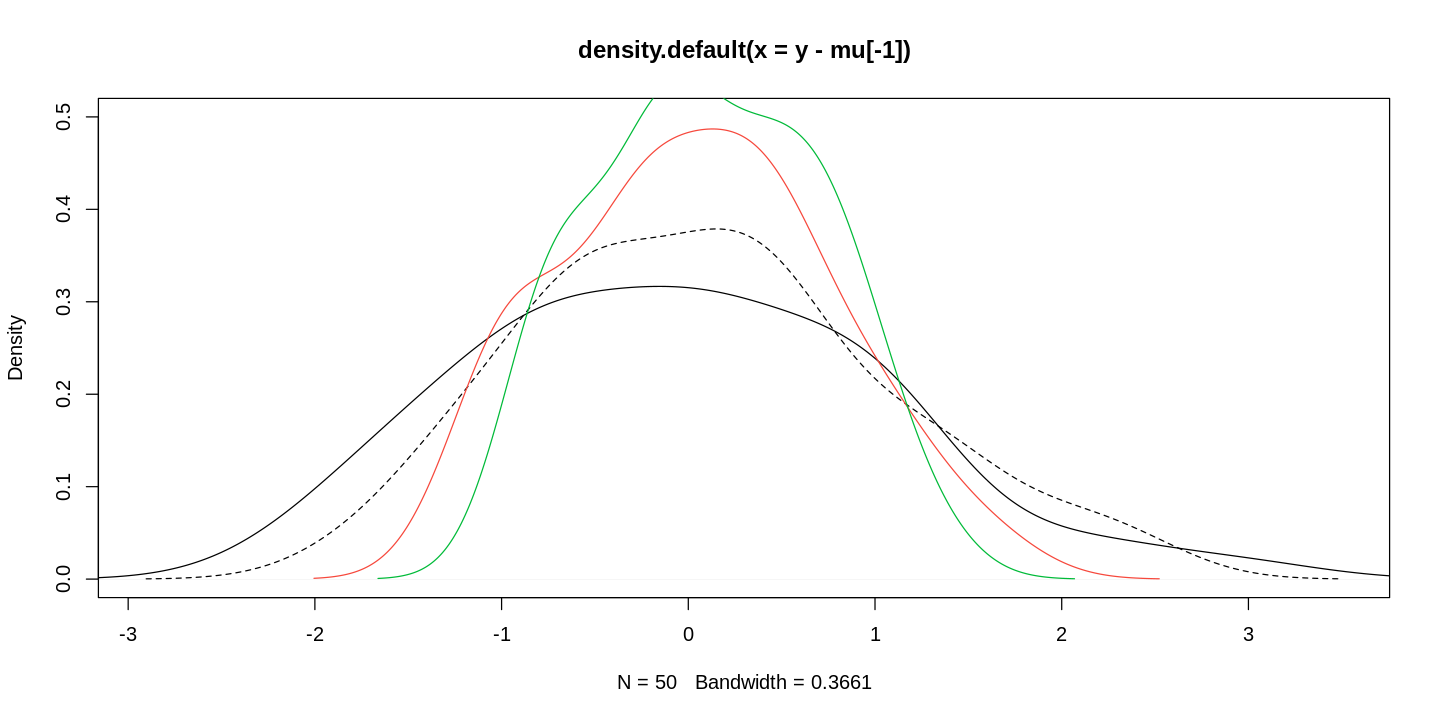

In [49]:
plot( density( y - mu[-1] ), ylim = c(0,.5), lty=2 )
lines( density( ks$xp - mu[-1] ),col=1 )
lines( density( ks$xf - mu[-1] ),col=2 )
lines( density( ks$xs - mu[-1] ),col=3 )

Can we interpret this?
- The noise $Y$ is in dashed black. This does better than the Kalman prediction. Is this surprising?
- The Kalman filter is in red and does better than $Y$
- The Kalman smoother is in green and does even better

Let's look at some other plots (these are from the book). We can incorporate the uncertainty

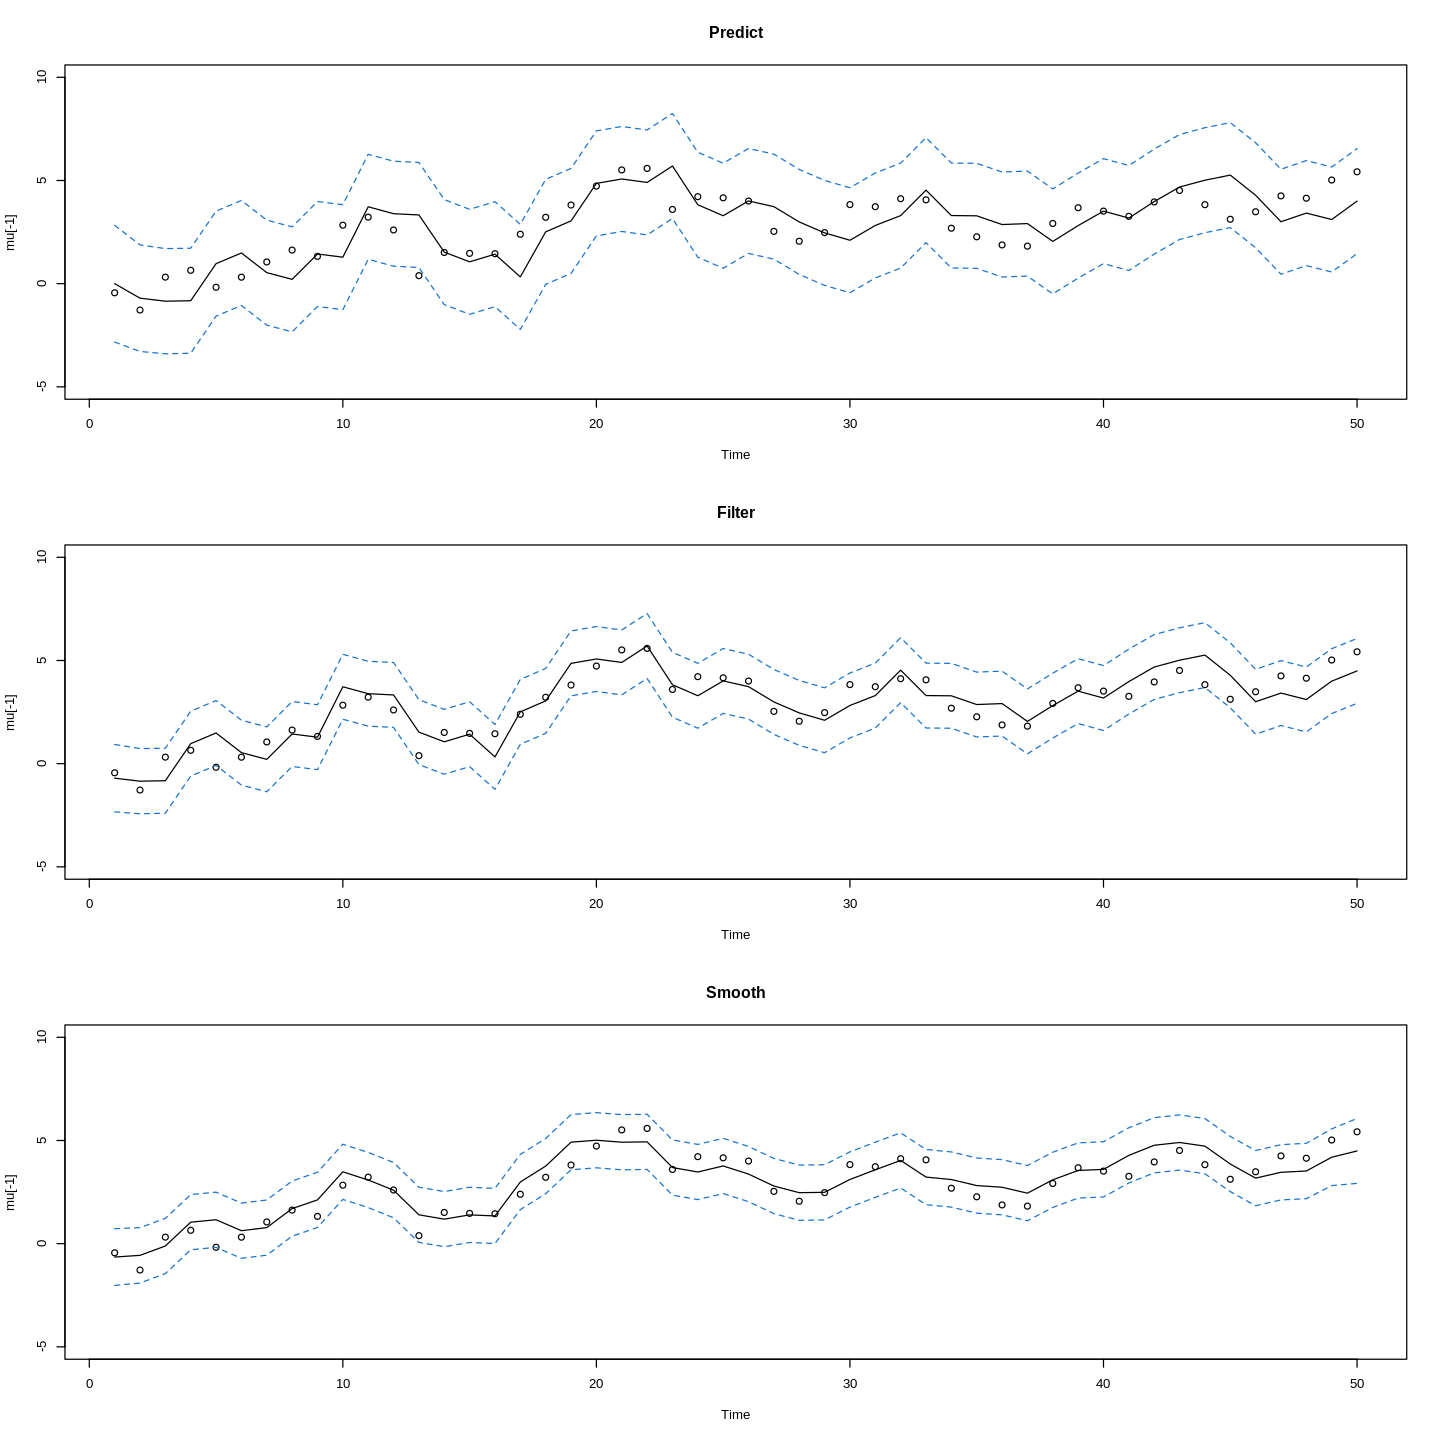

In [18]:
options(repr.plot.width = 12, repr.plot.height=12)
par(mfrow=c(3,1))

plot(Time, mu[-1], main='Predict', ylim=c(-5,10)) 
 lines(ks$xp) 
 lines(ks$xp+2*sqrt(ks$Pp), lty=2, col=4) 
 lines(ks$xp-2*sqrt(ks$Pp), lty=2, col=4)
plot(Time, mu[-1], main='Filter', ylim=c(-5,10)) 
 lines(ks$xf) 
 lines(ks$xf+2*sqrt(ks$Pf), lty=2, col=4) 
 lines(ks$xf-2*sqrt(ks$Pf), lty=2, col=4)
plot(Time, mu[-1], main='Smooth', ylim=c(-5,10)) 
 lines(ks$xs) 
 lines(ks$xs+2*sqrt(ks$Ps), lty=2, col=4)
 lines(ks$xs-2*sqrt(ks$Ps), lty=2, col=4)

### Let's do Kalman filtering ourselves
Our model:
$$ \mathbf{Y}_t = G_t \mathbf{X}_t + \mathbf{W}_t, \quad\text{Cov}(\mathbf{W}_t)=R_t $$
$$ \mathbf{X}_{t+1} = F_t \mathbf{X}_t + \mathbf{V}_t, \quad\text{Cov}(\mathbf{V}_t)=Q_t $$

... and as above, let's do the "local level" model (random walk + noise), i.e., the simplest kind of state-space model since $G_t=F_t=1$.

For the **Kalman prediction**, we need
$$ \hat{\mathbf{X}}_{1} = P( \mathbf{X}_{1} \mid \mathbf{Y}_0 ), \quad\Omega_1=\text{Cov}(\hat{\mathbf{X}}_{1})$$
where $\mathbf{Y}_0$ is prior knowledge (often the ones vector, to allow for an offset, or the zero vector if we know everything is zero mean).  We can take an uninformative prior and set $\hat{\mathbf{X}}_{1}=0$ and $\Omega_1 = Q_0$.

In [149]:
# generate data
set.seed(1)
num <- 50
Ft  <- 1  # i.e. 1x1 matrix
Gt  <- 1  # i.e. 1x1 matrix
cR  <- .6;  R <- cR^2
cQ  <- .2;  Q <- cQ^2
# Note: switching "v" and "w" notation to match Brockwell and Davis
#   (Shumway and Stoffer flip them)
v   <- rnorm(num+1,0,R) # variance is cR^2
# v[1] <- 0
w   <- rnorm(num,  0,Q) 
x   <- cumsum(v) # state: mu[0], mu[1],..., mu[50] 
y   <- x[-1]+ w  # obs: y[1],..., y[50]

In [150]:
Omega0 <- R
Omega  <- Omega0
xhat   <- rep(0,num+1)  # Kalman prediction
xfilt  <- rep(0,num)    # Kalman filter
xhat[1] <- 0 # initial guess
for (t in 1:num ){
  Delta <- Gt %*% Omega %*% t(Gt) + R
  Theta <- Ft %*% Omega %*% t(Gt)
  # The filter (not needed if just doing filtering)
  xfilt[t] <- xhat[t] + Omega %*% t(Gt) %*% solve(Delta, y[t] - Gt %*% xhat[t] )

  # The prediction (used in the filter also)
  xhat[t+1] <- Ft %*% xhat[t] + Theta %*% solve(Delta,  y[t] - Gt %*% xhat[t])
  # if not invertible, use pracma::pinv() or MASS:ginv()
  Omega <- Ft %*% Omega %*% t(Ft) + Q - Theta %*% solve(Delta, t(Omega) )
}

In [151]:
# Let's compare our answer with the ASTSA package
# In their notation, Q = cov(W) and R = cov(V), which is OK
# because our book switches the meaning of W and V
ks  <- astsa::Ksmooth0(num, y, A=Gt, mu0=0, Sigma0=Omega0, Phi=Ft, cQ=cQ, cR=cR)  # swap Q and R since swapping V and W

Compare the Kalman predictions with that from the `astsa` package

In [152]:
round(ks$xp, digits=5)
round(xhat[-(num+1)],  digits=5)

, , 1

     [,1]
[1,]    0

, , 2

         [,1]
[1,] -0.09679

, , 3

         [,1]
[1,] -0.23296

, , 4

         [,1]
[1,] -0.13229

, , 5

         [,1]
[1,] -0.00232

, , 6

        [,1]
[1,] 0.00325

, , 7

        [,1]
[1,] 0.03065

, , 8

        [,1]
[1,] 0.11814

, , 9

       [,1]
[1,] 0.2575

, , 10

        [,1]
[1,] 0.31784

, , 11

        [,1]
[1,] 0.54365

, , 12

        [,1]
[1,] 0.71754

, , 13

        [,1]
[1,] 0.78729

, , 14

        [,1]
[1,] 0.60467

, , 15

       [,1]
[1,] 0.5793

, , 16

        [,1]
[1,] 0.56705

, , 17

        [,1]
[1,] 0.53409

, , 18

        [,1]
[1,] 0.64333

, , 19

        [,1]
[1,] 0.79039

, , 20

       [,1]
[1,] 0.9791

, , 21

        [,1]
[1,] 1.18877

, , 22

        [,1]
[1,] 1.40535

, , 23

        [,1]
[1,] 1.58328

, , 24

        [,1]
[1,] 1.49128

, , 25

        [,1]
[1,] 1.48466

, , 26

        [,1]
[1,] 1.49166

, , 27

        [,1]
[1,] 1.47254

, , 28

        [,1]
[1,] 1.31433

, , 29

        [,1]
[1,] 1.15302

, , 30

        [,1]
[1,] 1.07225

, , 31

        [,1]
[1,] 1.15263

, , 32

        [,1]
[1,] 1.20477

, , 33

        [,1]
[1,] 1.29642

, , 34

        [,1]
[1,] 1.32621

, , 35

        [,1]
[1,] 1.23152

, , 36

        [,1]
[1,] 1.11844

, , 37

        [,1]
[1,] 1.00545

, , 38

        [,1]
[1,] 0.90289

, , 39

        [,1]
[1,] 0.94873

, , 40

        [,1]
[1,] 1.05805

, , 41

        [,1]
[1,] 1.11063

, , 42

        [,1]
[1,] 1.14237

, , 43

        [,1]
[1,] 1.23547

, , 44

        [,1]
[1,] 1.35367

, , 45

        [,1]
[1,] 1.37849

, , 46

        [,1]
[1,] 1.31276

, , 47

        [,1]
[1,] 1.28193

, , 48

        [,1]
[1,] 1.34588

, , 49

        [,1]
[1,] 1.37299

, , 50

       [,1]
[1,] 1.4905

[1]  0.00000 -0.09195 -0.22647 -0.12928 -0.00113  0.00406  0.03118  0.11843
 [9]  0.25764  0.31793  0.54368  0.71755  0.78730  0.60468  0.57930  0.56705
[17]  0.53410  0.64334  0.79039  0.97910  1.18877  1.40535  1.58328  1.49128
[25]  1.48466  1.49166  1.47254  1.31433  1.15302  1.07225  1.15263  1.20477
[33]  1.29642  1.32621  1.23152  1.11844  1.00545  0.90289  0.94873  1.05805
[41]  1.11063  1.14237  1.23547  1.35367  1.37849  1.31276  1.28193  1.34588
[49]  1.37299  1.49050

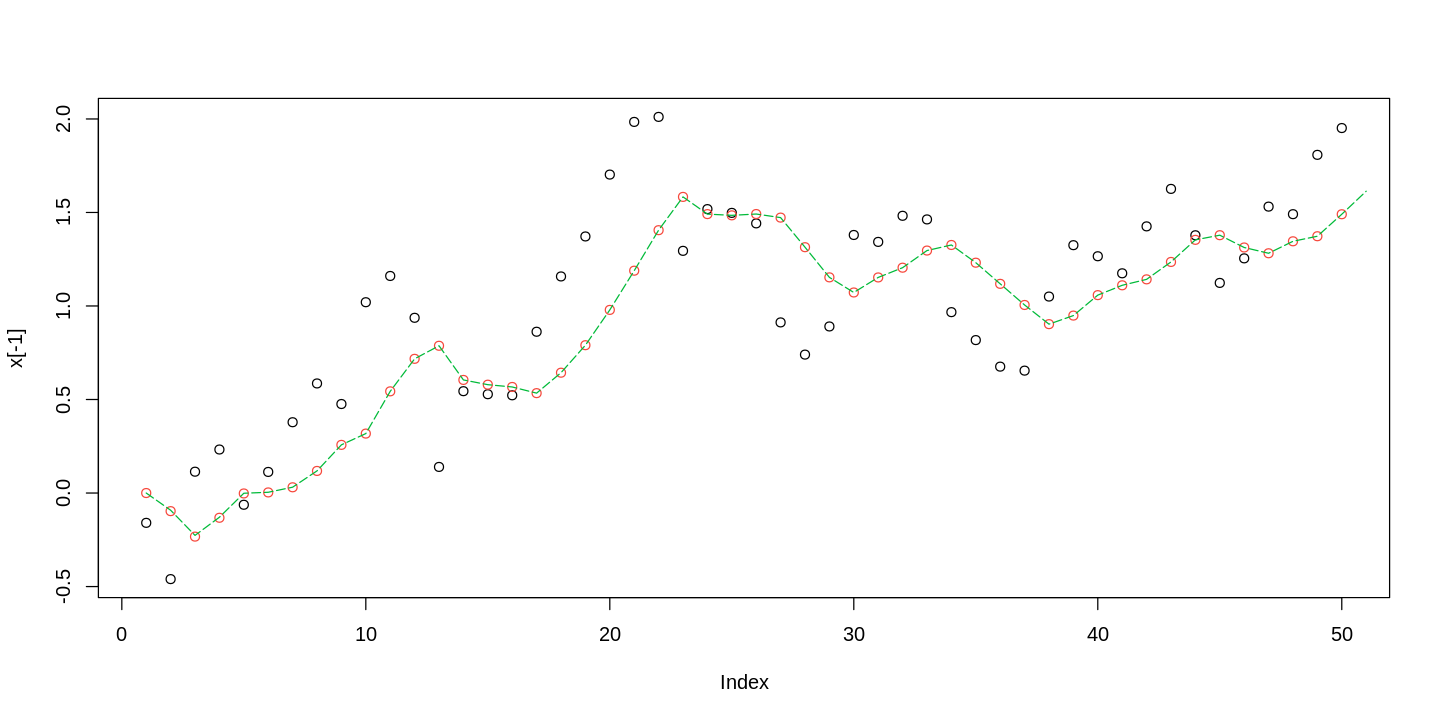

In [153]:
plot( x[-1] )
lines( ks$xp, col=2, lty=2,type='p')
lines( xhat,  col=3, lty=5,type='l')

Nice agreement!

Now compare the Kalman filtering solution with that of `astsa`:

In [154]:
round(ks$xf, digits=5)
round(xfilt, digits=5)

, , 1

         [,1]
[1,] -0.09679

, , 2

         [,1]
[1,] -0.23296

, , 3

         [,1]
[1,] -0.13229

, , 4

         [,1]
[1,] -0.00232

, , 5

        [,1]
[1,] 0.00325

, , 6

        [,1]
[1,] 0.03065

, , 7

        [,1]
[1,] 0.11814

, , 8

       [,1]
[1,] 0.2575

, , 9

        [,1]
[1,] 0.31784

, , 10

        [,1]
[1,] 0.54365

, , 11

        [,1]
[1,] 0.71754

, , 12

        [,1]
[1,] 0.78729

, , 13

        [,1]
[1,] 0.60467

, , 14

       [,1]
[1,] 0.5793

, , 15

        [,1]
[1,] 0.56705

, , 16

        [,1]
[1,] 0.53409

, , 17

        [,1]
[1,] 0.64333

, , 18

        [,1]
[1,] 0.79039

, , 19

       [,1]
[1,] 0.9791

, , 20

        [,1]
[1,] 1.18877

, , 21

        [,1]
[1,] 1.40535

, , 22

        [,1]
[1,] 1.58328

, , 23

        [,1]
[1,] 1.49128

, , 24

        [,1]
[1,] 1.48466

, , 25

        [,1]
[1,] 1.49166

, , 26

        [,1]
[1,] 1.47254

, , 27

        [,1]
[1,] 1.31433

, , 28

        [,1]
[1,] 1.15302

, , 29

        [,1]
[1,] 1.07225

, , 30

        [,1]
[1,] 1.15263

, , 31

        [,1]
[1,] 1.20477

, , 32

        [,1]
[1,] 1.29642

, , 33

        [,1]
[1,] 1.32621

, , 34

        [,1]
[1,] 1.23152

, , 35

        [,1]
[1,] 1.11844

, , 36

        [,1]
[1,] 1.00545

, , 37

        [,1]
[1,] 0.90289

, , 38

        [,1]
[1,] 0.94873

, , 39

        [,1]
[1,] 1.05805

, , 40

        [,1]
[1,] 1.11063

, , 41

        [,1]
[1,] 1.14237

, , 42

        [,1]
[1,] 1.23547

, , 43

        [,1]
[1,] 1.35367

, , 44

        [,1]
[1,] 1.37849

, , 45

        [,1]
[1,] 1.31276

, , 46

        [,1]
[1,] 1.28193

, , 47

        [,1]
[1,] 1.34588

, , 48

        [,1]
[1,] 1.37299

, , 49

       [,1]
[1,] 1.4905

, , 50

        [,1]
[1,] 1.61363

[1] -0.09195 -0.22647 -0.12928 -0.00113  0.00406  0.03118  0.11843  0.25764
 [9]  0.31793  0.54368  0.71755  0.78730  0.60468  0.57930  0.56705  0.53410
[17]  0.64334  0.79039  0.97910  1.18877  1.40535  1.58328  1.49128  1.48466
[25]  1.49166  1.47254  1.31433  1.15302  1.07225  1.15263  1.20477  1.29642
[33]  1.32621  1.23152  1.11844  1.00545  0.90289  0.94873  1.05805  1.11063
[41]  1.14237  1.23547  1.35367  1.37849  1.31276  1.28193  1.34588  1.37299
[49]  1.49050  1.61363

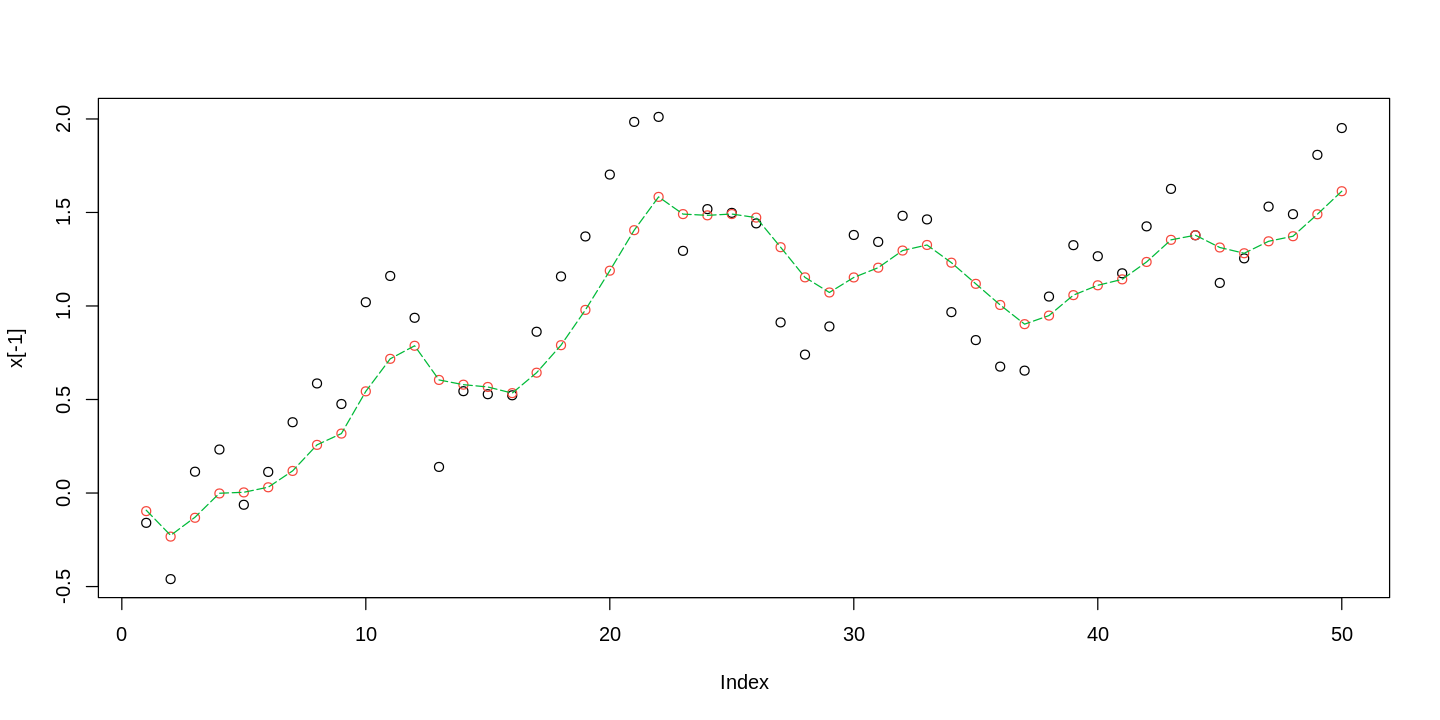

In [155]:
plot( x[-1] )
lines( ks$xf, col=2, lty=2,type='p')
lines( xfilt,  col=3, lty=5,type='l')

Again, nice agreement. Code seems correct, at least for 1D case